In [1]:
import numpy as np
import scipy.stats as sp
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import minmax_scale, scale, MinMaxScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss

In [5]:
from wgan.simulation import create_continuous_data
from wgan.imblearn import GANbalancer
import wgan.data_loader

In [6]:
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from types import MethodType

In [7]:
from sklearn.utils import safe_indexing

def create_samples(self, X, y):
        # FIXME: uncomment in version 0.6
        # self._validate_estimator()

        for class_sample, n_samples in self.sampling_strategy_.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = safe_indexing(X, target_class_indices)

            self.nn_k_.fit(X_class)
            nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
            X_new, y_new = self._make_samples(X_class, y.dtype, class_sample,
                                              X_class, nns, n_samples, 1.0)

        return X_new, y_new


SMOTE._sample_only = create_samples

## Artifical Data Generation

In [8]:
N_SAMPLES = 5000
N_VAR = 6
data = {
    "Independent" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=0, pos_ratio=0),
    "Dependent" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=5, pos_ratio=0),
    "Mixed" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=N_VAR//2, pos_ratio=0)
}
    

In [9]:
gan_balancer = GANbalancer(idx_cont=range(N_VAR), categorical=None, auxiliary=False,
                           gan_architecture = "fisher",
                           generator_input=N_VAR*1, generator_layers=[N_VAR*4], 
                           critic_layers=[N_VAR*4], critic_iterations=3,
                           learning_rate = [1e-4, 1e-4],
                           batch_size = 128, n_iter=10000, 
                           sampling_strategy = {0:N_SAMPLES, 1:0}, verbose=2)

In [10]:
smote = SMOTE(sampling_strategy = {0:N_SAMPLES, 1:0})
smote._validate_estimator()
smote.sampling_strategy_ = {0:N_SAMPLES, 1:0}

In [11]:
def check_first_moments(X):
    return np.vstack([x.mean(axis=0) for x in X])

def check_second_moments(X):
    return [np.cov(x, rowvar=False).round(2) for x in X]

## Univariate Normal RVs - First and Second Moment Approximation

In [12]:
gan_balancer._fit(data["Independent"][0], y=np.zeros(shape=N_SAMPLES))

100%|██████████| 10000/10000 [07:07<00:00, 19.91it/s]


GANbalancer(auxiliary=False, batch_size=128, categorical=None,
      critic_iterations=3, critic_layers=[24], gan_architecture='fisher',
      generator_input=6, generator_layers=[24], idx_cont=range(0, 6),
      learning_rate=[0.0001, 0.0001], n_iter=10000, random_state=None,
      sampling_strategy={0: 5000, 1: 0}, verbose=2)

In [ ]:
gan_balancer.trainer.print_every = 1

In [ ]:
gan_balancer._update(data["Independent"][0], y=np.zeros(shape=N_SAMPLES), 
                     n_iter=10000)

  0%|          | 40/10000 [00:01<05:40, 29.23it/s]

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


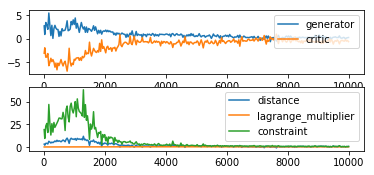

In [13]:
fig = gan_balancer.trainer.plot_training()
fig

In [14]:
check_first_moments([data["Independent"][0], 
                     gan_balancer.generator.sample_data(N_SAMPLES),
                     smote._sample(data["Independent"][0], y=np.zeros(shape=N_SAMPLES))[0]
                    ])

array([[ 0.72157369,  0.29882856,  1.75030332,  0.2084523 , -0.41721768,
         0.21028026],
       [ 0.95694131, -0.02140257,  1.59734547,  0.26369724, -0.16621137,
         0.05366584],
       [ 0.72064859,  0.30110338,  1.75353251,  0.21796107, -0.41820652,
         0.21383217]])

In [15]:
check_second_moments([data["Independent"][0], 
                     gan_balancer.generator.sample_data(N_SAMPLES),
                     smote._sample(data["Independent"][0], y=np.zeros(shape=N_SAMPLES))[0]
                    ])

[array([[ 1.01,  0.02, -0.02,  0.01,  0.01,  0.01],
        [ 0.02,  1.  ,  0.01, -0.01,  0.01, -0.02],
        [-0.02,  0.01,  1.01,  0.01, -0.01, -0.01],
        [ 0.01, -0.01,  0.01,  0.99, -0.03,  0.02],
        [ 0.01,  0.01, -0.01, -0.03,  1.01,  0.02],
        [ 0.01, -0.02, -0.01,  0.02,  0.02,  0.99]]),
 array([[ 0.02,  0.02,  0.01,  0.03, -0.02,  0.  ],
        [ 0.02,  0.06, -0.06,  0.03,  0.  , -0.02],
        [ 0.01, -0.06,  0.22, -0.01, -0.01,  0.03],
        [ 0.03,  0.03, -0.01,  0.07, -0.07, -0.02],
        [-0.02,  0.  , -0.01, -0.07,  0.1 ,  0.03],
        [ 0.  , -0.02,  0.03, -0.02,  0.03,  0.04]]),
 array([[ 0.93,  0.02, -0.03,  0.01,  0.01, -0.01],
        [ 0.02,  0.95,  0.01, -0.01,  0.01, -0.02],
        [-0.03,  0.01,  0.96,  0.01, -0.01, -0.02],
        [ 0.01, -0.01,  0.01,  0.93, -0.03,  0.02],
        [ 0.01,  0.01, -0.01, -0.03,  0.96,  0.02],
        [-0.01, -0.02, -0.02,  0.02,  0.02,  0.93]])]

## Multivariate Normal RVs - Covariance Approximation 

In [16]:
data_idx = "Dependent"

In [17]:
gan_balancer._fit(data[data_idx][0], y=np.zeros(shape=N_SAMPLES))

100%|██████████| 100000/100000 [26:48<00:00, 111.25it/s]


GANbalancer(auxiliary=False, batch_size=128, categorical=None,
      critic_iterations=3, critic_layers=[6, 6], gan_architecture='fisher',
      generator_input=6, generator_layers=[6, 6], idx_cont=range(0, 6),
      learning_rate=[0.0001, 0.0001], n_iter=100000, random_state=None,
      sampling_strategy={0: 5000, 1: 0}, verbose=2)

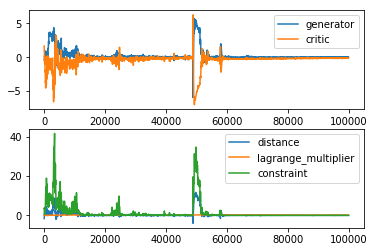

In [20]:
fig = gan_balancer.trainer.plot_training()
fig

In [18]:
check_first_moments([data[data_idx][0], 
                     gan_balancer.generator.sample_data(N_SAMPLES),
                     smote._sample(data[data_idx][0], y=np.zeros(shape=N_SAMPLES))[0]
                    ])

array([[ 3.57181739e-01,  6.80303905e-01, -1.38280654e-02,
         1.00526250e-01,  1.06223741e-01, -3.92726191e-01],
       [ 2.93796897e-01,  5.13601303e-01, -1.09738119e-01,
         5.51787554e-04,  1.02493152e-01, -2.09657595e-01],
       [ 3.46348008e-01,  6.76197161e-01, -1.43476223e-02,
         1.01793904e-01,  1.06465236e-01, -3.91604194e-01]])

Covariance matrix extimate is very close to true covariance matrix, e.g. 
TRUE  ([[ 0.21, -0.11, -0.11, -0.14,  0.1 ],
        [-0.11,  0.32,  0.08,  0.07, -0.23],
        [-0.11,  0.08,  0.13,  0.11, -0.08],
        [-0.14,  0.07,  0.11,  0.21, -0.07],
        [ 0.1 , -0.23, -0.08, -0.07,  0.24]]),
        
 GAN  ([[ 0.21, -0.09, -0.12, -0.17,  0.11],
        [-0.09,  0.23,  0.07,  0.07, -0.14],
        [-0.12,  0.07,  0.13,  0.13, -0.06],
        [-0.17,  0.07,  0.13,  0.21, -0.06],
        [ 0.11, -0.14, -0.06, -0.06,  0.2 ]]),
        
SMOTE ([[ 0.21, -0.11, -0.11, -0.14,  0.1 ],
        [-0.11,  0.32,  0.08,  0.07, -0.23],
        [-0.11,  0.08,  0.13,  0.11, -0.08],
        [-0.14,  0.07,  0.11,  0.21, -0.07],
        [ 0.1 , -0.23, -0.08, -0.07,  0.23]])]

In [19]:
check_second_moments([data[data_idx][0], 
                     gan_balancer.generator.sample_data(N_SAMPLES),
                     smote._sample(data[data_idx][0], y=np.zeros(shape=N_SAMPLES))[0]
                    ])

[array([[ 0.99, -0.  , -0.  ,  0.  ,  0.01,  0.  ],
        [-0.  ,  0.11, -0.04, -0.02, -0.04,  0.04],
        [-0.  , -0.04,  0.11,  0.02,  0.07, -0.05],
        [ 0.  , -0.02,  0.02,  0.07,  0.04, -0.04],
        [ 0.01, -0.04,  0.07,  0.04,  0.15, -0.07],
        [ 0.  ,  0.04, -0.05, -0.04, -0.07,  0.1 ]]),
 array([[ 0.14, -0.01, -0.01, -0.  , -0.  ,  0.  ],
        [-0.01,  0.  ,  0.  , -0.  ,  0.  ,  0.  ],
        [-0.01,  0.  ,  0.  , -0.  ,  0.  ,  0.  ],
        [-0.  , -0.  , -0.  ,  0.01,  0.  , -0.  ],
        [-0.  ,  0.  ,  0.  ,  0.  ,  0.01, -0.  ],
        [ 0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.01]]),
 array([[ 0.99, -0.01, -0.  ,  0.01,  0.01,  0.  ],
        [-0.01,  0.11, -0.04, -0.02, -0.04,  0.04],
        [-0.  , -0.04,  0.1 ,  0.02,  0.06, -0.05],
        [ 0.01, -0.02,  0.02,  0.06,  0.04, -0.03],
        [ 0.01, -0.04,  0.06,  0.04,  0.15, -0.07],
        [ 0.  ,  0.04, -0.05, -0.03, -0.07,  0.1 ]])]

## Critic data cleaning

Use the critic to select samples that are more realistic from a larger set of generated observations. 

In [ ]:
sample = gan_balancer.generator(gan_balancer.generator.sample_latent(N_SAMPLES*20))

In [ ]:
idx_critic = np.argsort(
    gan_balancer.critic(sample).detach().numpy().flatten()
                         )
idx_lowest = idx_critic[:N_SAMPLES].copy()
idx_highest = idx_critic[-N_SAMPLES:].copy()

In [ ]:
idx_lowest

Critic output is in the range $[-\inf;0]$ where higher is less difference to the real distribution. 

In [ ]:
sample_np = sample.detach().numpy()

In [ ]:
sample_lowest = sample_np[idx_lowest,:].copy()
sample_random = sample_np[np.random.choice(range(0,N_SAMPLES), size=N_SAMPLES),:].copy()
sample_highest = sample_np[idx_highest,:].copy()

In [ ]:
check_first_moments([data["Independent"][0], 
                     sample_highest,
                     sample_np,
                     sample_lowest
                    ])

In [ ]:
check_second_moments([data["Independent"][0], 
                     sample_highest,
                     sample_np,
                     sample_lowest
                    ])

## Visual test

In [ ]:
combinations = [(x,y) for x in range(no_vars) for y in range(no_vars) if y>x]

In [ ]:
fig, axes = plt.subplots(nrows=no_vars, ncols=no_vars, sharex=True, sharey=True, squeeze=True,figsize=(10,10))
for y in axes:
    for x in y:
        x.set_xticklabels([])
        x.set_yticklabels([])

for i,j in combinations:
    sns.kdeplot(X_majority[:,i], X_majority[:,j], alpha=0.5, cmap="Blues", ax=axes[(j,i)])
    sns.kdeplot(X_minority[:,i], X_minority[:,j], alpha=0.5, cmap="Greens", ax=axes[(j,i)])
fig.savefig(f'../img/cont_sample_tr_iter_{trainer.G.training_iterations}.png',format='png', dpi=100)
    #fig.show()

In [ ]:
epochs = 90

for _ in range(30):
    trainer.train(data_loader, epochs)
    
    
    if modus == 'full':
        fake_minority = generator(*generator.sample_latent(num_samples= 1000, class_index=1)).data.numpy()
        fake_majority = generator(*generator.sample_latent(num_samples= 1000, class_index=0)).data.numpy()
    elif modus == 'minority':
        fake_minority = generator(generator.sample_latent(num_samples= 1000)).data.numpy()
        
    fig, axes = plt.subplots(nrows=no_vars, ncols=no_vars, sharex=True, squeeze=True,figsize=(10,10))
    for y in axes:
        for x in y:
            x.set_xticklabels([])
            x.set_yticklabels([])
    
    for i in range(no_vars):
        sns.kdeplot(X_minority[:,i], alpha=0.5, shade=True, color="blue", ax=axes[(i,i)])
        sns.kdeplot(fake_minority[:,i], alpha=0.5, shade=True, color="green", ax=axes[(i,i)])
    
    for i,j in combinations:
        axes[(i,j)].set_ylim(0,1)
        # majority (upper right)
        if modus == 'full':
            sns.kdeplot(X_majority[0:1000,i], X_majority[0:1000,j], alpha=0.5, cmap="Blues", ax=axes[(i,j)])
            sns.kdeplot(fake_majority[:,i], fake_majority[:,j], alpha=0.5, cmap="Greens", ax=axes[(i,j)], )
        
        # minority (lower left)
        sns.kdeplot(X_minority[:,i], X_minority[:,j], alpha=0.5, cmap="Blues", ax=axes[(j,i)])
        sns.kdeplot(fake_minority[:,i], fake_minority[:,j], alpha=0.5, cmap="Greens", ax=axes[(j,i)])
        
    fig.savefig(f'../img/cont_sample_tr_iter_{trainer.G.training_iterations}.png',format='png', dpi=200)
        #fig.show()

In [ ]:
desc = f"multinormal_n{N//1000}_k{no_vars}_{modus}"
torch.save(generator.state_dict(), f"../models/wgan_generator_{desc}_{generator.training_iterations}")
torch.save(discriminator.state_dict(), f"../models/wgan_discriminator_{desc}_{generator.training_iterations}")

In [ ]:
file_name = "multinormal_n10_k4_c2_6999"
generator.load_state_dict(torch.load(f"../models/wgan_generator_{file_name}"))
discriminator.load_state_dict(torch.load(f"../models/wgan_discriminator_{file_name}"))

## Distribution summary statistics

In [ ]:
from torch import Tensor as T

In [ ]:
fake_minority = generator(*generator.sample_latent(num_samples= minority_samples, class_index=1)).data.numpy()

In [ ]:
print(np.mean(X_minority, axis=0))
print(np.mean(fake_minority, axis=0))

In [ ]:
print(np.quantile(X_minority, q=np.arange(0,1,0.1), axis=0))
print(np.quantile(fake_minority, q=np.arange(0,1,0.1), axis=0))

In [ ]:
print(np.cov(X_minority, rowvar=False) - np.cov(fake_minority,rowvar=False))


## Discriminator test

In [ ]:
sample_size = X_minority.shape[0]

In [ ]:
fake = generator(*generator.sample_latent(num_samples= sample_size, class_index=1)).data.numpy()
#fake = generator(generator.sample_latent(num_samples= sample_size)).data.numpy()

In [ ]:
X_fakereal = np.vstack([X_minority, 
                        fake])
y_fakereal = np.concatenate([np.zeros(X_minority.shape[0]), 
                        np.ones(fake.shape[0])]).flatten()

In [ ]:
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=20, n_jobs=10)
model_fakereal = clf.fit(X_fakereal, y_fakereal)

In [ ]:
pred_fakereal = model_fakereal.predict_proba(X_fakereal)[:,1]
roc_auc_score(y_fakereal, pred_fakereal)

# Predictive performance testing

In [ ]:
y_train_bin = np.argmax(y_train, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
def test_auc(model_library, X, y_true):
    auc = {}
    for model in model_library.keys():
        pred = model_library[model].predict_proba(X_test)[:,1]
        auc[model] = roc_auc_score(y_true, pred)
    return auc

## Predictive test

In [ ]:
minority_samples = X_minority.shape[0]
majority_samples = X_majority.shape[0]

fake_minority = generator(*generator.sample_latent(num_samples= minority_samples, class_index=1)).data.numpy()
fake_majority = generator(*generator.sample_latent(num_samples= majority_samples, class_index=0)).data.numpy()

X_synthetic = np.vstack([fake_majority, 
                         fake_minority])
y_synthetic = np.concatenate([np.zeros(majority_samples), 
                              np.ones(minority_samples)]).flatten()

In [ ]:
clf_org = DecisionTreeClassifier(max_depth=10) #LogisticRegression(solver='saga') 
clf_fake = DecisionTreeClassifier(max_depth=10) #LogisticRegression(solver='saga')

predictive = {}
predictive["real"] = clf_org.fit(X=X_train, y=y_train_bin)
predictive["synthetic"] = clf_fake.fit(X=X_synthetic, y=y_synthetic)

test_auc(predictive, X_test, y_test)

## Upsampling performance

In [ ]:
performance = {"original":[],"GANbalanced":[]}
for i in range(200):
    sample_size = X_minority.shape[0]*4
    X_fake = generator(*generator.sample_latent(num_samples= sample_size, class_index=1)).data.numpy()
    #X_fake = generator(generator.sample_latent(num_samples= sample_size, class_index=None)).data.numpy()
    y_fake = np.ones(shape=[sample_size])

    X_up = np.vstack([X_train,X_fake])
    y_up = np.hstack([y_train_bin,y_fake])

    clf_org = DecisionTreeClassifier(max_depth=5)
    clf_fake = DecisionTreeClassifier(max_depth=5)

    upsampling = {}
    upsampling["original"] =  clf_org.fit(X=X_train, y=y_train_bin)
    upsampling["GANbalanced"] = clf_fake.fit(X=X_up, y=y_up)
    
    performance_temp = test_auc(upsampling, X_test, y_test_bin)
    for model in performance_temp:
        performance[model].append(performance_temp[model])
    

In [ ]:
print(pd.DataFrame(performance).mean())
print(pd.DataFrame(performance).std())

In [ ]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plot_decision_function(X_train, y_train, upsampling["original"], ax1)
plot_decision_function(X_up, y_up, upsampling["GANbalanced"], ax2)

fig.tight_layout()